# 3D Kinematic Pathing
by Edbert Wang

 
This optimization model seeks to address how 3D kinematic pathing can be represented in modeling languages like gams. This specific example will demonstrate a drone control system to investigate this problem. Fully autonomous drones can be used in many applications such as delivery, visual surveying, or safe inspections. The principles here are relevant to many of these applications, thus investigating their implementation will help us better understand the key concepts behind them.

### Display Configurables
Setting the below booleans to true will determine which features will be enabled in the output graph.
Turning on these graph booleans will increase both memory footprint and runtime.


In [1]:
velocity_graph = True
accel_graph = True
obstacle_graph = True

In [2]:
# Environment setup
%load_ext gams_magic
m = gams.exchange_container

## Data Entry
The model supports 5 main editable variables:
* Mass of the object: **m** - change the scalar to whatever mass is desired
* Number of timesteps: **N** - change x in /0*x/ to the desired number of timesteps
* Max power output: **b** - change the scalar to desired limit
* Time limit: **T** - change the scalar to desired number of seconds
* Gravity: **g** - change the scalar to desired downwards acceleration
 
Additionally, the model supports custom setpoint and obstacle definition:
 
Set Points: Points that the drone is required to hit at a designated time.
* Note: Be careful with setting the locations to be too large, potentially causing memory overflow. Limits unknown
* Format: pos.fx(axis,timestep) = location;
* Example:
pos.fx("x","20") = 100;
pos.fx("y","20") = 100;
pos.fx("z","20") = 100;
 
Obstacles: Cubic regions that the drone has to avoid entering
* **p** should be changed such that the x in /1*x/ reflects the desired number of obstacles
* There should be a row in **objcenter** for each obstacle, ensure data aligns with axis indicators (x,y,z in first row) or else the model may crash
* For each obstacle, there should be an associated "radius" designated by 'obstacle_number size'

In [3]:
%%gams
set ax "All movement should be done per axis" /x,y,z/;
scalar m "Mass in kilograms" /20/;
set N "Number of intervals" /0*20/;
scalar b "Max power output" /500/;
scalar T "Time limit in seconds" /20/;
scalar g /9.8/;

positive Variable pos(ax,N);
pos.fx("x","5") = 10;
pos.fx("y","5") = 20;
pos.fx("z","5") = 40;

pos.fx("x","13") = 40;
pos.fx("y","13") = 60;
pos.fx("z","13") = 60;

pos.fx("x","20") = 100;
pos.fx("y","20") = 100;
pos.fx("z","20") = 100;


set p "Number of obstacles" /1*3/;
table objcenter(p,ax)
    x    y    z
1   10   10   10
2   20   20   20
3   50   30   50
;
parameter size(p) /1 5,2 10,3 20/;

## Model Description

This problem is an optimal control problem. The goal is to create a path that contacts the setpoints at the set times while avoiding all of the obstacles that minimizes the power consumption.
The model will be based on a simple dynamics model that uses an Euler discretization to simulate the effects of acceleration and velocity. At each timestep, the difference in this velocity and the previous velocity will be set equal to the acceleration, and then the difference in position will be set equal to the new velocity.
 
Obstacles will be simulated through the use of 3 binary indicator variables, each of which will check if the drone is overlapping with the obstacle's boundaries for one of the 3 axes through a modified big M formulation. We then ensure that at maximum 2 of the 3 indicators can be active at once, thus the drone will never be allowed to enter the zones bounded by the boxes.

In [4]:
%%gams
free variable energy;
positive Variable force(ax,N),velocity(ax,N),accel(ax,N),u(ax,N);
velocity.fx(ax,"0") = 0;
pos.fx(ax,"0") = 0;

Parameter dt;
dt = (T/(card(N) - 1));

equations in(ax,N),vel(ax,N),obj,acc(ax,N),u1(ax,N),u2(ax,N),thrustlim(N);
u1(ax,N)..
-u(ax,N) =l= force(ax,N);

u2(ax,N)..
u(ax,N) =g= force(ax,N);

thrustlim(N)..
sum(ax,u(ax,N)) =l= b;

vel(ax,N)$(N.ord lt card(N))..
(pos(ax,N + 1) - pos(ax,N)) =e= velocity(ax,N) * dt;

acc(ax,N)$(N.ord lt card(N))..
(velocity(ax,N + 1) - velocity(ax,N)) =e= (accel(ax,N) - g$(ord(ax)=3)) * dt;

in(ax,N)..
force(ax,N) =e= m * accel(ax,N);

obj..
sum((ax,N),u(ax,N)) =e= energy;


* For obstacles, we model them as large boxes, then use 3 binary indicators per obstacle
* turn on when the values are in between 2 inequalities, then ensure that all 3 cannot be on at the same time
binary variable bp(p,ax,N);
positive Variable distp(p,ax,N);
equations dup(p,ax,N),dlp(p,ax,N),inp(p,ax,N),sp(p,N);

* Create a distance variable that is the absolute value of distance of drone from the object
dup(p,ax,N)..
-distp(p,ax,N) =l= objcenter(p,ax) - pos(ax,N);

dlp(p,ax,N)..
distp(p,ax,N) =g= objcenter(p,ax) - pos(ax,N);


* binary forced to 0 if distance away from obstacle center it less than its size
inp(p,ax,N)..
distp(p,ax,N) =g= bp(p,ax,N) * size(p);


* For each timestamp at most 2 binaries can be 0 without the drone intersecting with obstacle
sp(p,N)..
sum(ax,bp(p,ax,N)) =g= 1;


model rocket /all/;
solve rocket using mip min energy;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),4205.7143,961,694,MIP,CPLEX,0.015


## Graph Generation

The following code is used to create a 3D plot of the path of the drone. By default, the graph will contain the path of the drone in both line and scatter plot form (blue). Based on which of the graph booleans are turned on, the graph can additionally contain the wireframes representing the obstacles (black), vectors representing velocity (green), and vectors representing acceleration (red).

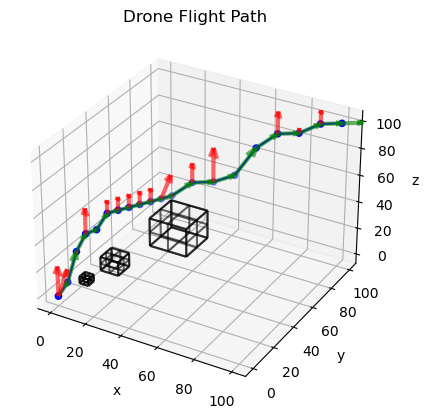

In [5]:
from mpl_toolkits import mplot3d
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
pos = m.data['pos'].records[['level']]
x = pos['level'][:len(pos) // 3]
y = pos['level'][len(pos) // 3 : len(pos) // 3 * 2]
z = pos['level'][len(pos) // 3 * 2:]

ax.scatter(x, y, z,color = 'blue')
ax.plot(x, y, z,color = 'blue')

if obstacle_graph:
    def plot_cuboid(center, s, ax):
        ox, oy, oz = center

        x = np.linspace(ox-s/2,ox+s/2,num=3)
        y = np.linspace(oy-s/2,oy+s/2,num=3)
        z = np.linspace(oz-s/2,oz+s/2,num=3)
        x1, z1 = np.meshgrid(x, z)
        y11 = np.ones_like(x1)*(oy-s/2)
        y12 = np.ones_like(x1)*(oy+s/2)
        x2, y2 = np.meshgrid(x, y)
        z21 = np.ones_like(x2)*(oz-s/2)
        z22 = np.ones_like(x2)*(oz+s/2)
        y3, z3 = np.meshgrid(y, z)
        x31 = np.ones_like(y3)*(ox-s/2)
        x32 = np.ones_like(y3)*(ox+s/2)

        # outside surface
        ax.plot_wireframe(x1, y11, z1, color='black', rstride=1, cstride=1, alpha=0.6)
        # inside surface
        ax.plot_wireframe(x1, y12, z1, color='black', rstride=1, cstride=1, alpha=0.6)
        # bottom surface
        ax.plot_wireframe(x2, y2, z21, color='black', rstride=1, cstride=1, alpha=0.6)
        # upper surface
        ax.plot_wireframe(x2, y2, z22, color='black', rstride=1, cstride=1, alpha=0.6)
        # left surface
        ax.plot_wireframe(x31, y3, z3, color='black', rstride=1, cstride=1, alpha=0.6)
        # right surface
        ax.plot_wireframe(x32, y3, z3, color='black', rstride=1, cstride=1, alpha=0.6)
    
    
    objs = m.data['objcenter'].records[['value']]
    objsize = m.data['size'].records[['value']]

    for obj in range(len(objsize)):
        plot_cuboid([int(objs.iloc[obj * 3]),int(objs.iloc[obj * 3 + 1]),int(objs.iloc[obj * 3 + 2])], int(objsize.iloc[obj]), ax)

if velocity_graph:
    vel = m.data['velocity'].records[['level']]
    vx = vel['level'][:len(pos) // 3]
    vy = vel['level'][len(pos) // 3 : len(pos) // 3 * 2]
    vz = vel['level'][len(pos) // 3 * 2:]

    ax.quiver(
            x, y, z, 
            vx, vy, vz,
            color = 'green', alpha = .6, lw = 3,
    )

if accel_graph:
    accel = m.data['accel'].records[['level']]
    acx = accel['level'][:len(pos) // 3]
    acy = accel['level'][len(pos) // 3 : len(pos) // 3 * 2]
    acz = accel['level'][len(pos) // 3 * 2:]
    ax.quiver(
            x, y, z,
            acx, acy, acz,
            color = 'red', alpha = .6, lw = 3,
    )

ax.set_title('Drone Flight Path')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()
plt.close()

In [6]:
%gams_cleanup --closedown

## Conclusion
 
Overall, this model is a successful demonstration of a simple flight path generator. The model can efficiently generate the optimal path a drone should take to reach a point while avoiding obstacles. The model has been set up in a way that custom data can be fed into the model and evaluated easily. From testing with various variable, setpoint, and obstacle combinations, I believe that the model can optimize power consumption a variety of problems.

## Further Improvements/Spec Deviations
 
There are some improvements that I would have liked to make:

First, this model assumes no outside forces. Originally I was intending to add wind as a constant delta V to the drone, but that was inconsistent with how wind would work in a realistic setting. The drone wouldn't know beforehand how much wind would be present at each timestep. I could have potentially done a stochastic formulation to simulate variable wind conditions, but the exact equations to control the recourse motor action eluded me.
 
Second, I wanted to add a python based input layer. The current gams input cell is very syntax dependent, and the errors thrown when something fails don't help solve the problem. The original plan was to add this layer, but I was unable to due to complications with the gms - python interface packages.

Third, I wanted to create a default model that was based on a real life purchaseable drone. However, scaling that drone to my enviroment's memory constrains proved to be impossible. Instead, I have just choosen a series of variables that I though made an interesting path.